# <span style='background:Yellow'> Bottom Temp & Salt difference between ECCO and WOA

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.aae61b4bf06c4bc7a30eeb77b837a592/status,


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
import geopandas
import scipy
import xesmf as xe

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
woa_path = '/home/jovyan/WMT-project/WOA/'
ecco_path = '/home/jovyan/WMT-project/ECCO-budgets/'

woa8110_pt = xr.open_dataset(woa_path+'pt_bottom_wg_8110.nc')
woa8110_pt_error = xr.open_dataset(woa_path+'pt_bottom_error.nc')
woa8110_slt = xr.open_dataset(woa_path+'san_bottom_wg_8110.nc')
woa8110_slt_error = xr.open_dataset(woa_path+'san_bottom_error.nc')

woa0517_pt = xr.open_dataset(woa_path+'pt_bottom_wg_0517.nc')
woa0517_pt_error = xr.open_dataset(woa_path+'pt_bottom_0517_error.nc')
woa0517_slt = xr.open_dataset(woa_path+'/san_bottom_wg_0517.nc')
woa0517_slt_error = xr.open_dataset(woa_path+'san_bottom_wg_0517_error.nc')

ecco_temp = xr.open_dataset(ecco_path+'bottom_temp_wg.nc')
#ecco_std_temp = xr.open_dataset(ecco_path+'bottom_std_temp_ecco.nc')
ecco_slt = xr.open_dataset(ecco_path+'bottom_slt_wg.nc')
#ecco_std_slt = xr.open_dataset(ecco_path+'bottom_std_slt_ecco.nc')

surface_mask = xr.open_dataset('/home/jovyan/WMT-project/ECCO-budgets/surface_mask.nc')
depth = xr.open_dataset('/home/jovyan/WMT-project/ECCO-budgets/depth_wg.nc')

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.9/ssl.py", line 1310, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1129)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle_read()
  File "/srv/conda/envs/notebook/lib/python3.9/site

# <span style='background:Pink'> <font color='Red'> Temperature </font>

In [6]:
ecco_temp = ecco_temp.THETA.drop(['i','j']).mean(dim='time')

In [7]:
ecco_temp

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.5656109 ,  1.8291065 ,  1.6809775 , ..., -0.60746783,
        -0.60745776, -0.6074615 ],
       [ 0.13080378,  0.25096482,  1.8400244 , ..., -0.60863906,
        -0.6083164 , -0.608207  ],
       [ 0.12459682,  0.0798245 ,  0.19863093, ..., -0.61016595,
        -0.6093797 , -0.60912585]], dtype=float32)
Coordinates:
    k        (j, i) int64 ...
    lat      (j, i) float32 ...
    lon      (j, i) float32 ...
Dimensions without coordinates: j, i

In [8]:
woa8110_pt

<xarray.Dataset>
Dimensions:  (time: 1, lat: 19, lon: 96)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lev      (time, lat, lon) float64 ...
  * lat      (lat) float64 -79.5 -78.5 -77.5 -76.5 ... -64.5 -63.5 -62.5 -61.5
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 27.5 28.5 29.5 30.5
Data variables:
    PT       (time, lat, lon) float64 ...

### <span style='color:Brown'> Interpolating WOA (1981-2010) temp data onto ECCO's grid

In [9]:
regridder = xe.Regridder(woa8110_pt, ecco_temp, method='bilinear')

woa8110_pt_new_grid = regridder(woa8110_pt)
woa8110_pt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, j: 50, i: 95)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
Dimensions without coordinates: j, i
Data variables:
    PT       (time, j, i) float64 0.0 0.0 0.0 0.0 ... -0.7204 -0.7081 -0.6951
Attributes:
    regrid_method:  bilinear

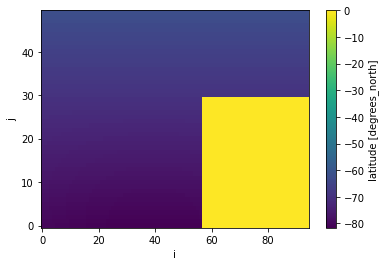

In [10]:
ecco_temp.lat.plot()

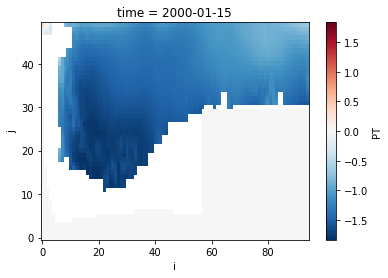

In [11]:
woa8110_pt_new_grid.PT[0].plot()

### <span style='color:Brown'> Interpolating WOA (1981-2010) temp error data onto ECCO's grid

In [12]:
regridder_8110_error = xe.Regridder(woa8110_pt_error, ecco_temp, method='bilinear')

woa8110_pt_error_new_grid = regridder(woa8110_pt_error)
woa8110_pt_error_new_grid

<xarray.Dataset>
Dimensions:   (time: 1, j: 50, i: 95)
Coordinates:
  * time      (time) object -001-01-15 00:00:00
    lon       (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    lat       (j, i) float32 -80.07 -80.14 -80.21 ... -62.22 -62.22 -62.22
Dimensions without coordinates: j, i
Data variables:
    PT_error  (time, j, i) float64 0.0 0.0 0.0 0.0 ... 0.2958 0.4598 0.3391
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom temperature `ECCO - WOA` (1981-2010) </font>

In [13]:
#checking if nans
print(np.isnan(ecco_temp.sum()))

<xarray.DataArray 'THETA' ()>
array(False)


In [13]:
ecco_woa8110_diff = ecco_temp - woa8110_pt_new_grid.isel(time=0).PT
ecco_woa8110_diff

<xarray.DataArray (j: 50, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.63575033,  2.07516944,  1.94412458, ...,  0.25510106,
         0.2433311 ,  0.22895014],
       [ 0.03369812,  0.34266563,  2.02375475, ...,  0.1893589 ,
         0.17839337,  0.16403622],
       [-0.17822455, -0.03236783,  0.22024657, ...,  0.11020843,
         0.0987603 ,  0.0859307 ]])
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    time     datetime64[ns] 2000-01-15
Dimensions without coordinates: j, i

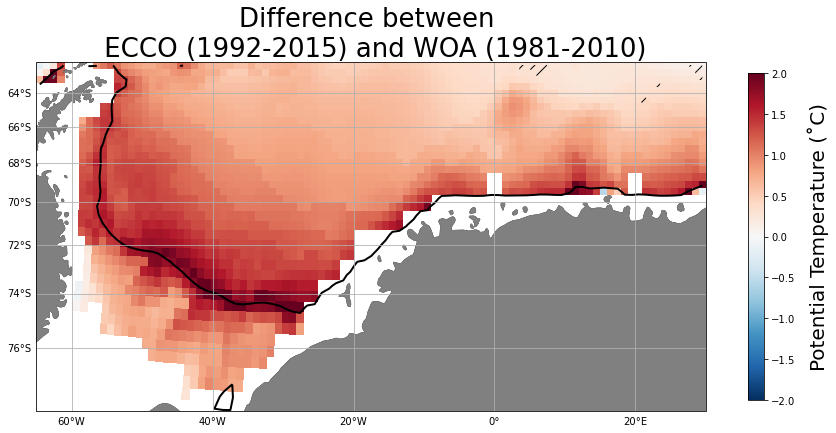

In [23]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(ecco_woa8110_diff.lon, ecco_woa8110_diff.lat, 
           depth.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(ecco_woa8110_diff.lon, 
                   ecco_woa8110_diff.lat, 
                   ecco_woa8110_diff.where(surface_mask.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-2, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature (˚C)", labelpad=12, fontsize=20)

plt.contourf(ecco_woa8110_diff.lon, 
             ecco_woa8110_diff.lat,  
             ecco_woa8110_diff.where(np.abs(ecco_woa8110_diff) < woa8110_pt_error_new_grid.PT_error[0]).where(surface_mask.hFacC),
             transform=ccrs.PlateCarree(), colors='none', hatches=['//'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n ECCO (1992-2015) and WOA (1981-2010)", fontsize=26)
plt.savefig('bot-temp-eccoWoa8110-1kmisobath.pdf');

### <span style='color:Brown'> Interpolating WOA (2005-2017) temp data onto ECCO's grid

In [16]:
regridder_0517 = xe.Regridder(woa0517_pt, ecco_temp, method='bilinear')

woa0517_pt_new_grid = regridder_0517(woa0517_pt)
woa0517_pt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, j: 50, i: 95)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
Dimensions without coordinates: j, i
Data variables:
    PT       (time, j, i) float64 0.0 0.0 0.0 0.0 ... -0.8279 -0.8171 -0.8026
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (2005-2017) temp ERROR data onto ECCO's grid

In [17]:
regridder_0517_error = xe.Regridder(woa0517_pt_error, ecco_temp, method='bilinear')

woa0517_pt_error_new_grid = regridder_0517_error(woa0517_pt_error)
woa0517_pt_error_new_grid

<xarray.Dataset>
Dimensions:   (time: 1, j: 50, i: 95)
Coordinates:
  * time      (time) object -001-01-15 00:00:00
    lon       (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    lat       (j, i) float32 -80.07 -80.14 -80.21 ... -62.22 -62.22 -62.22
Dimensions without coordinates: j, i
Data variables:
    PT_error  (time, j, i) float64 0.0 0.0 0.0 0.0 ... 0.852 0.4471 0.4978
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom temperature `ECCO - WOA` (2005-2017) </font>

In [18]:
ecco_temp

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.5656109 ,  1.8291065 ,  1.6809775 , ..., -0.60746783,
        -0.60745776, -0.6074615 ],
       [ 0.13080378,  0.25096482,  1.8400244 , ..., -0.60863906,
        -0.6083164 , -0.608207  ],
       [ 0.12459682,  0.0798245 ,  0.19863093, ..., -0.61016595,
        -0.6093797 , -0.60912585]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
Dimensions without coordinates: j, i

In [19]:
ecco_woa0517_diff = ecco_temp - woa0517_pt_new_grid.isel(time=0).PT
ecco_woa0517_diff

<xarray.DataArray (j: 50, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.88361031, 2.24873682, 2.07543391, ..., 0.35274895, 0.3460978 ,
        0.33264542],
       [0.29412797, 0.52133069, 2.14992165, ..., 0.29290499, 0.28415616,
        0.27041006],
       [0.09586968, 0.16637828, 0.37163759, ..., 0.21770693, 0.20767789,
        0.19349591]])
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    time     datetime64[ns] 2000-01-15
Dimensions without coordinates: j, i

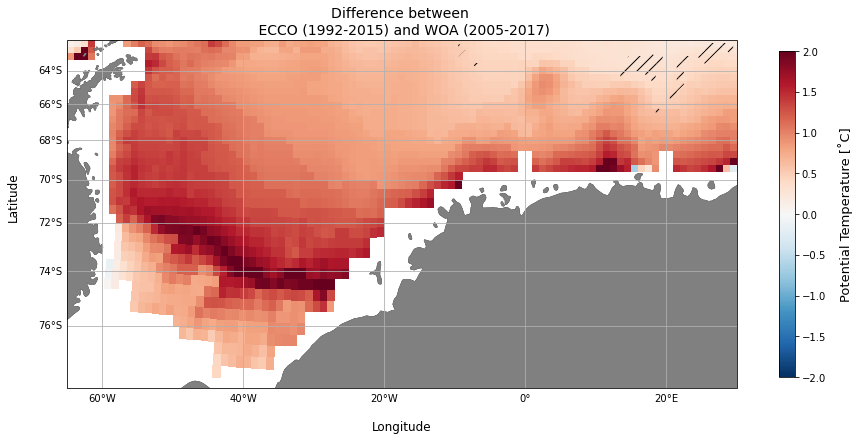

In [20]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ecco_woa0517_diff.lon, 
                   ecco_woa0517_diff.lat, 
                   ecco_woa0517_diff.where(surface_mask.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-2, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

plt.contourf(ecco_woa0517_diff.lon, 
             ecco_woa0517_diff.lat,  
             ecco_woa0517_diff.where(np.abs(ecco_woa0517_diff) < woa0517_pt_error_new_grid.PT_error[0]).where(surface_mask.hFacC),
             transform=ccrs.PlateCarree(), colors='none', hatches=['//'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n ECCO (1992-2015) and WOA (2005-2017)", fontsize=14);

# <span style='background:Pink'> <font color='Red'> Salinity </font>

In [24]:
ecco_slt = ecco_slt.SALT.mean(dim='time')

In [25]:
ecco_slt

<xarray.DataArray 'SALT' (j: 50, i: 95)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [34.712536, 34.676   , 34.642563, ..., 34.6691  , 34.668694,
        34.66834 ],
       [34.702305, 34.706024, 34.67171 , ..., 34.669205, 34.668774,
        34.66839 ],
       [34.702038, 34.700333, 34.704147, ..., 34.66935 , 34.668922,
        34.668484]], dtype=float32)
Coordinates:
    k        (j, i) int64 ...
  * i        (i) int64 23 24 25 26 27 28 29 30 ... 111 112 113 114 115 116 117
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 ...
    lon      (j, i) float32 ...

### <span style='color:Brown'> Interpolating WOA (1981-2010) salt data onto ECCO's grid

In [26]:
regridder_slt = xe.Regridder(woa8110_slt, ecco_slt, method='bilinear')

woa8110_slt_new_grid = regridder_slt(woa8110_slt)
woa8110_slt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, j: 50, i: 95)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
Dimensions without coordinates: j, i
Data variables:
    san      (time, j, i) float32 0.0 0.0 0.0 0.0 ... 34.65 34.65 34.65 34.65
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (1981-2010) salt ERROR data onto ECCO's grid

In [27]:
regridder_slt_error = xe.Regridder(woa8110_slt_error.sse.fillna(0.), ecco_slt, method='bilinear')

woa8110_slt_error_new_grid = regridder_slt_error(woa8110_slt_error)
woa8110_slt_error_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, j: 50, i: 95)
Coordinates:
  * time     (time) object -001-01-15 00:00:00
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
Dimensions without coordinates: j, i
Data variables:
    sse      (time, j, i) float32 0.0 0.0 0.0 ... 0.0001364 0.0002919 0.0002876
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom salinity `ECCO - WOA` (1981-2010) </font>

In [20]:
#checking if nans
print(np.isnan(ecco_slt.sum()))

<xarray.DataArray 'SALT' ()>
array(False)


In [28]:
ecco_woa8110_slt_diff = ecco_slt - woa8110_slt_new_grid.isel(time=0).san
ecco_woa8110_slt_diff

<xarray.DataArray (j: 50, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.00993347, -0.03452301, -0.02911758, ...,  0.01802444,
         0.01728058,  0.01816559],
       [ 0.00202942,  0.01102066, -0.03024673, ...,  0.01825333,
         0.0175972 ,  0.01849365],
       [ 0.0030098 ,  0.00997162, -0.0030632 , ...,  0.01887894,
         0.01834106,  0.01863861]], dtype=float32)
Coordinates:
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 23 24 25 26 27 28 29 30 ... 111 112 113 114 115 116 117
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    time     datetime64[ns] 2000-01-15

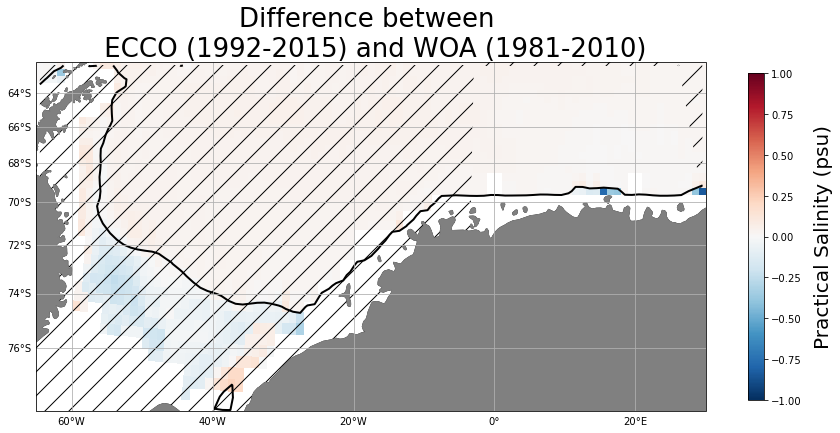

In [29]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(ecco_woa8110_diff.lon, ecco_woa8110_diff.lat, 
           depth.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(ecco_woa8110_slt_diff.lon, 
                   ecco_woa8110_slt_diff.lat, 
                   ecco_woa8110_slt_diff.where(surface_mask.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1, vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity (psu)", labelpad=12, fontsize=20)

plt.contourf(ecco_woa8110_slt_diff.lon, 
             ecco_woa8110_slt_diff.lat, 
             ecco_woa8110_slt_diff.where(np.abs(ecco_woa8110_slt_diff) < woa8110_slt_error_new_grid.sse[0]).where(surface_mask.hFacC).fillna(0.),
             transform=ccrs.PlateCarree(), colors='none', hatches=['/'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n ECCO (1992-2015) and WOA (1981-2010)", fontsize=26)
plt.savefig('bot-salt-eccoWoa8110-1kmisobath.pdf');

### <span style='color:Brown'> Interpolating WOA (2005-2017) salt data onto ECCO's grid

In [28]:
regridder_0517_slt = xe.Regridder(woa0517_slt, ecco_slt, method='bilinear')

woa0517_slt_new_grid = regridder_0517_slt(woa0517_slt)
woa0517_slt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, j: 50, i: 95)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
Dimensions without coordinates: j, i
Data variables:
    san      (time, j, i) float32 0.0 0.0 0.0 0.0 ... 34.65 34.65 34.65 34.65
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (2005-2017) salt ERROR data onto ECCO's grid

In [29]:
regridder_0517_slt_error = xe.Regridder(woa0517_slt_error, ecco_slt, method='bilinear')

woa0517_slt_error_new_grid = regridder_0517_slt_error(woa0517_slt_error)
woa0517_slt_error_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, j: 50, i: 95)
Coordinates:
  * time     (time) object -001-01-15 00:00:00
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
Dimensions without coordinates: j, i
Data variables:
    sse      (time, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0001441 0.0 nan nan
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom salinity `ECCO - WOA` (2005-2017) </font>

In [30]:
ecco_woa0517_slt_diff = ecco_slt - woa0517_slt_new_grid.isel(time=0).san
ecco_woa0517_slt_diff

<xarray.DataArray (j: 50, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.01148224, -0.04678726, -0.04484177, ...,  0.01805115,
         0.01741028,  0.01828766],
       [ 0.00318146,  0.00828552, -0.03334808, ...,  0.01834488,
         0.01775742,  0.01872635],
       [ 0.00381851,  0.01115036, -0.0019722 , ...,  0.01898575,
         0.01849365,  0.01894379]], dtype=float32)
Coordinates:
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    time     datetime64[ns] 2000-01-15

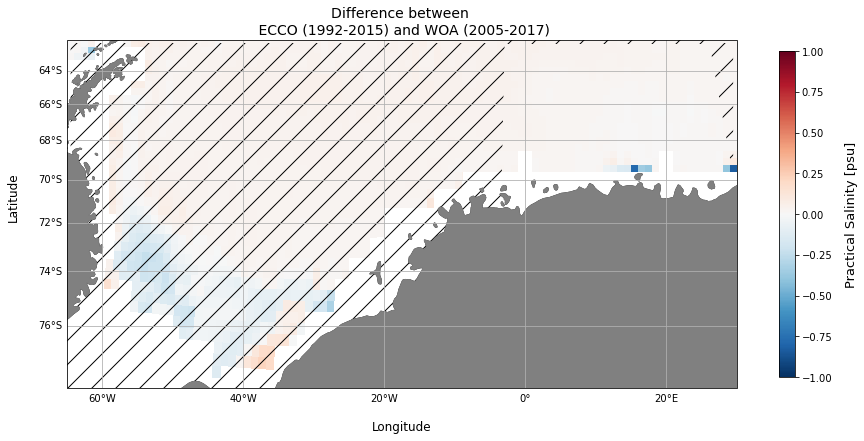

In [31]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ecco_woa0517_slt_diff.lon, 
                   ecco_woa0517_slt_diff.lat, 
                   ecco_woa0517_slt_diff.where(surface_mask.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1, vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity [psu]", labelpad=12, fontsize=13)

plt.contourf(ecco_woa0517_slt_diff.lon, 
             ecco_woa0517_slt_diff.lat, 
             ecco_woa0517_slt_diff.where(np.abs(ecco_woa0517_slt_diff) < woa0517_slt_error_new_grid.sse[0]).where(surface_mask.hFacC).fillna(0.),
             transform=ccrs.PlateCarree(), colors='none', hatches=['/'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n ECCO (1992-2015) and WOA (2005-2017)", fontsize=14);